In [1]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import warnings

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 5
N_REPEATS = 1

# Loading Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv', index_col='id')[:100_000]
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col='id')

In [4]:
train.head(10).T

id,0,1,2,3,4,5,6,7,8,9
MonsoonIntensity,5.000,6.00,6.00,3.000,5.000,5.00,8.00,6.000,5.000,4.000
TopographyDrainage,8.000,7.00,5.00,4.000,3.000,4.00,3.00,6.000,2.000,2.000
RiverManagement,5.000,4.00,6.00,6.000,2.000,1.00,1.00,5.000,8.000,3.000
Deforestation,8.000,4.00,7.00,5.000,6.000,4.00,2.00,7.000,5.000,5.000
Urbanization,6.000,8.00,3.00,4.000,4.000,2.00,3.00,5.000,4.000,8.000
ClimateChange,4.000,8.00,7.00,8.000,4.000,4.00,7.00,5.000,5.000,6.000
DamsQuality,4.000,3.00,1.00,4.000,3.000,6.00,3.00,3.000,2.000,5.000
Siltation,3.000,5.00,5.00,7.000,3.000,6.00,4.00,5.000,4.000,5.000
AgriculturalPractices,3.000,4.00,4.00,6.000,3.000,7.00,6.00,5.000,5.000,7.000
Encroachments,4.000,6.00,5.00,8.000,3.000,5.00,7.00,5.000,5.000,6.000


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,100000.0,4.921610,2.057136,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,100000.0,4.933180,2.100533,0.000,3.00,5.000,6.00,17.000
RiverManagement,100000.0,4.957280,2.070096,0.000,4.00,5.000,6.00,16.000
Deforestation,100000.0,4.942030,2.045231,0.000,4.00,5.000,6.00,15.000
Urbanization,100000.0,4.943530,2.079241,0.000,3.00,5.000,6.00,17.000
ClimateChange,100000.0,4.928300,2.059151,0.000,3.00,5.000,6.00,16.000
DamsQuality,100000.0,4.943890,2.081467,0.000,4.00,5.000,6.00,16.000
Siltation,100000.0,4.923360,2.074456,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,100000.0,4.946770,2.066635,0.000,4.00,5.000,6.00,16.000
Encroachments,100000.0,4.947700,2.078150,0.000,4.00,5.000,6.00,17.000


# Preprocessing
- I'm incorporating a new feature which was suggested [here](https://www.kaggle.com/competitions/playground-series-s4e5/discussion/499274).
- I've also added a few other statistical features which have been suggested on the forums by various people.

In [6]:
def add_stat_features(dataframe, cols):
    dataframe['_sum'] = dataframe[cols].sum(1)
    dataframe['_var'] = dataframe[cols].var(1)
    dataframe['_prod'] = dataframe[cols].prod(1)
    dataframe['_mean'] = dataframe[cols].mean(1)
    dataframe['_skew'] = dataframe[cols].skew(1)
    dataframe['_median'] = dataframe[cols].median(1)
    dataframe['_kurtosis'] = dataframe[cols].kurtosis(1)
    dataframe['_abs_energy'] = dataframe[cols].abs().sum(1)
    dataframe['_gmean'] = dataframe[cols].apply(lambda x: np.exp(np.log(x).mean()), axis=1)
    dataframe['_hmean'] = dataframe[cols].apply(lambda x: len(x) / np.sum(1.0/x), axis=1)
    return dataframe
        
feature_cols = list(test.columns)
target_col = 'FloodProbability'

**I will be running three different experiments with three variations of the dataset. These datasets will be used to train a predefined set of regressors.**

1. Using the original dataset to train the models
2. Adding statistical features and removing the original features before training
3. Using both original and added statistical features for training

In [7]:
# Original data
train_0 = train.copy()

# Data with statistical features
train_1 = train.copy()
train_1 = add_stat_features(train_1, feature_cols)
train_1 = train_1.drop(feature_cols, axis=1)

# Data with original and statistical features
train_2 = train.copy()
train_2 = add_stat_features(train_2, feature_cols)

del train

In [8]:
X_0 = train_0.drop(target_col, axis=1)
y_0 = train_0[target_col]

X_1 = train_1.drop(target_col, axis=1)
y_1 = train_1[target_col]

X_2 = train_2.drop(target_col, axis=1)
y_2 = train_2[target_col]

del train_0, train_1, train_2

# Training Models

In [9]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [10]:
models = [
    CatBoostRegressor(random_state=SEED, verbose=False),
    LGBMRegressor(random_state=SEED, verbose=-1),
    GradientBoostingRegressor(random_state=SEED),
    XGBRegressor(random_state=SEED, n_jobs=-1),
    HistGradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED, n_jobs=-1),
    LinearRegression(n_jobs=-1)
]

In [11]:
model_scores_0 = {}
model_preds_0 = {}
for model in models:
    scores, preds = Trainer(model, X_0, y_0, N_SPLITS, N_REPEATS).fit()
    model_scores_0[model.__class__.__name__] = scores
    model_preds_0[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.84498 ± 0.00189
LGBMRegressor: 0.76143 ± 0.00133
GradientBoostingRegressor: 0.61293 ± 0.00182
XGBRegressor: 0.78471 ± 0.00261
HistGradientBoostingRegressor: 0.76057 ± 0.00146
ExtraTreesRegressor: 0.60927 ± 0.00135
LinearRegression: 0.84543 ± 0.00196


In [12]:
model_scores_1 = {}
model_preds_1 = {}
for model in models:
    scores, preds = Trainer(model, X_1, y_1, N_SPLITS, N_REPEATS).fit()
    model_scores_1[model.__class__.__name__] = scores
    model_preds_1[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.86719 ± 0.00133
LGBMRegressor: 0.86732 ± 0.00147
GradientBoostingRegressor: 0.86638 ± 0.00146
XGBRegressor: 0.86470 ± 0.00185
HistGradientBoostingRegressor: 0.86729 ± 0.00129
ExtraTreesRegressor: 0.82326 ± 0.00246
LinearRegression: 0.84575 ± 0.00194


In [13]:
model_scores_2 = {}
model_preds_2 = {}
for model in models:
    scores, preds = Trainer(model, X_2, y_2, N_SPLITS, N_REPEATS).fit()
    model_scores_2[model.__class__.__name__] = scores
    model_preds_2[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.86654 ± 0.00145
LGBMRegressor: 0.86721 ± 0.00140
GradientBoostingRegressor: 0.86626 ± 0.00141
XGBRegressor: 0.86420 ± 0.00184
HistGradientBoostingRegressor: 0.86721 ± 0.00137
ExtraTreesRegressor: 0.86365 ± 0.00156
LinearRegression: 0.84571 ± 0.00195


# Visualizing the Results

In [14]:
def plot_scores(df, title):
    sns.set_style("white") 
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.boxplot(data=df, orient='h', palette='viridis', ax=axes[0], order=df.mean().sort_values(ascending=False).index.tolist())
    axes[0].set_title(f'Fold Scores ({title})')
    axes[0].set_xlabel('') 
    axes[0].set_ylabel('')

    mean_scores = df.mean().sort_values(ascending=True)
    mean_scores.plot(kind='barh', ax=axes[1], color='skyblue')
    axes[1].set_title(f'Mean Scores ({title})')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    for j, score in enumerate(mean_scores):
        axes[1].text(score, j, f'{score:.5f}', ha='left', va='center')
    axes[1].set_xlim(mean_scores.min() - 0.05, mean_scores.max() + 0.05)
        
    plt.tight_layout()
    plt.show()

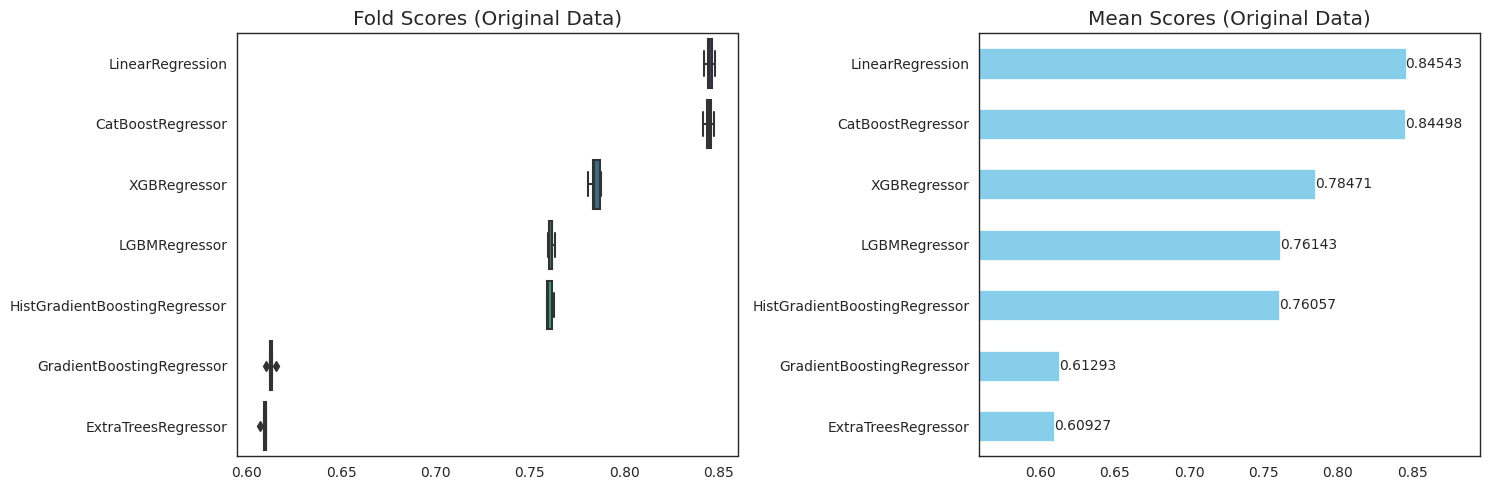

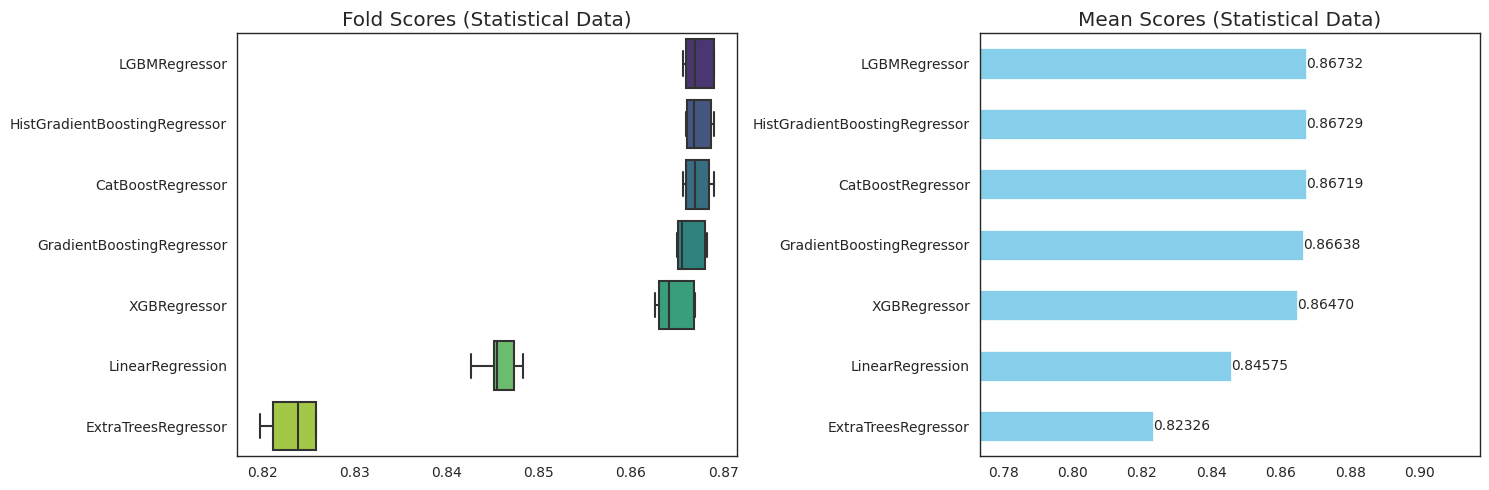

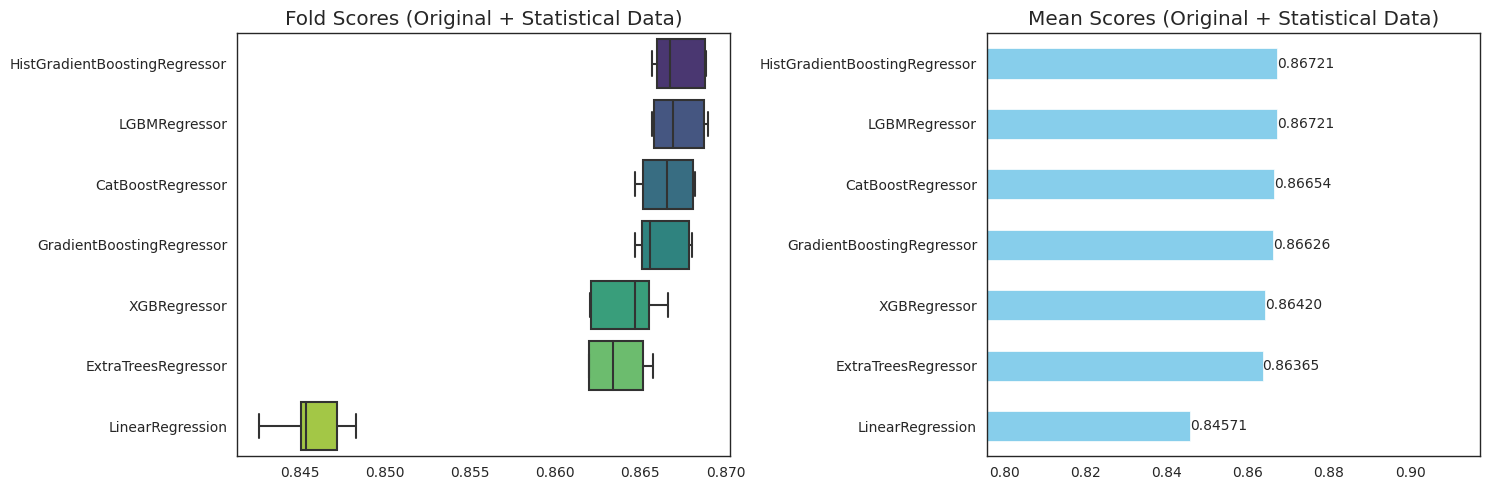

In [15]:
model_scores_df_0 = pd.DataFrame(model_scores_0)
model_scores_df_1 = pd.DataFrame(model_scores_1)
model_scores_df_2 = pd.DataFrame(model_scores_2)

plot_scores(model_scores_df_0, 'Original Data')
plot_scores(model_scores_df_1, 'Statistical Data')
plot_scores(model_scores_df_2, 'Original + Statistical Data')

In [16]:
def plot_residuals(model_preds, y, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for model_name, model_pred in model_preds.items():
        axes[0].scatter(y, model_pred, alpha=0.5, s=15, label=model_name)
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title(f'Actual vs. Predicted ({title})')
    axes[0].legend(loc='best', fontsize=8)

    for model_name, model_pred in model_preds.items():
        axes[1].scatter(model_pred, y - model_pred, alpha=0.5, s=15, label=model_name)
    axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'Residual Plot ({title})')
    axes[1].legend(loc='best', fontsize=8)

    plt.tight_layout()
    plt.show()

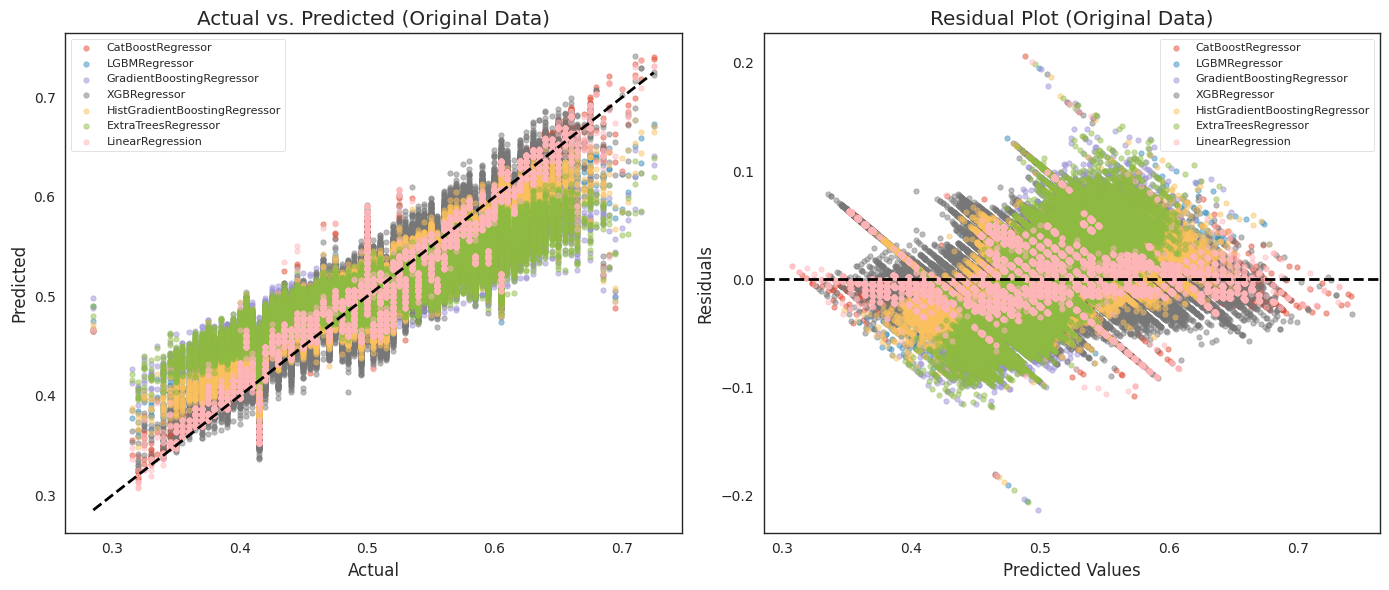

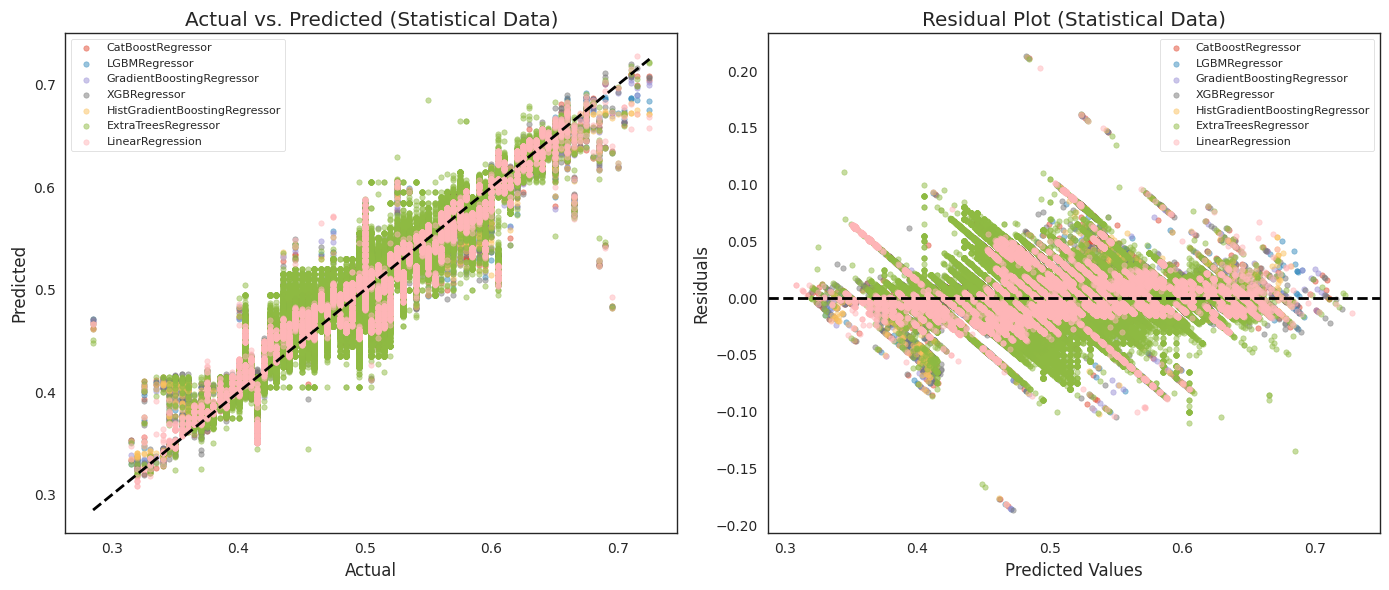

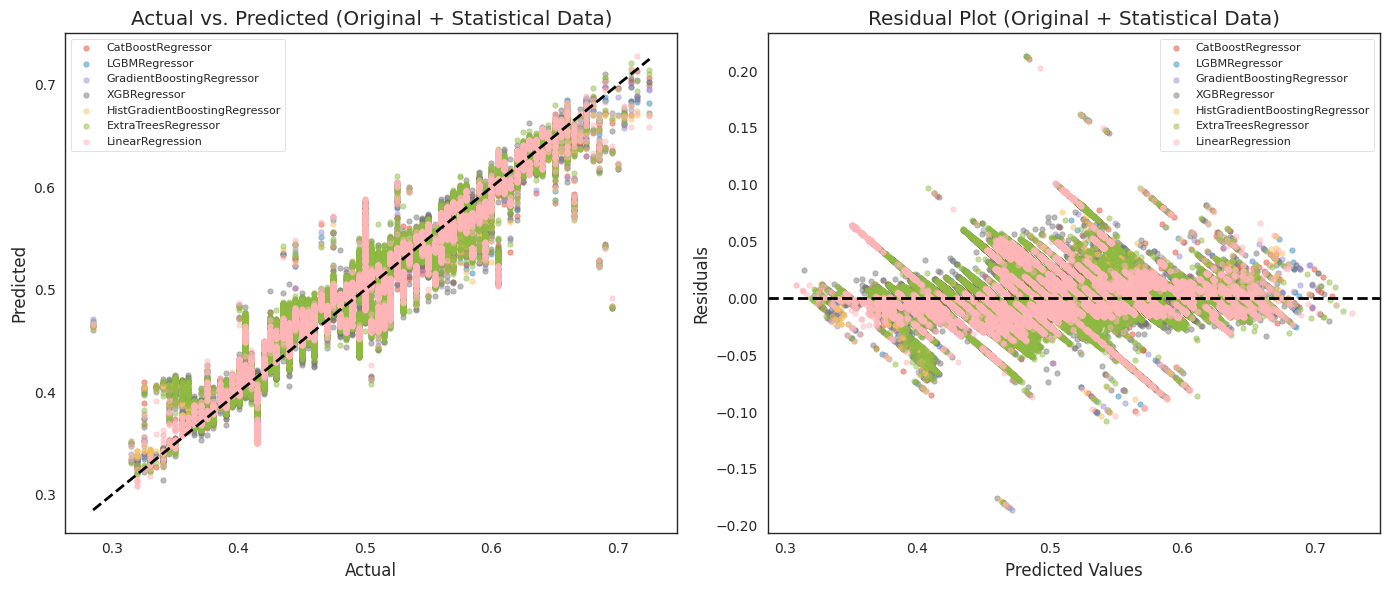

In [17]:
plot_residuals(model_preds_0, y_0, 'Original Data')
plot_residuals(model_preds_1, y_1, 'Statistical Data')
plot_residuals(model_preds_2, y_2, 'Original + Statistical Data')

In [18]:
def plot_cdfs(model_preds, y, title):
    sns.set_style("white")
    fig = plt.figure(figsize=[15, 10])

    sns.ecdfplot(data=y, stat='proportion', complementary=False, label='Target')
    for model, preds in model_preds.items():
        sns.ecdfplot(data=preds, stat='proportion', complementary=False, label=model)

    plt.title(f'Cumulative Distribution Function ({title})', fontsize=15)
    plt.xlabel('Flood Probability', fontsize=10)
    plt.ylabel('Proportion', fontsize=10)
    plt.legend()

    plt.tight_layout()
    plt.show()

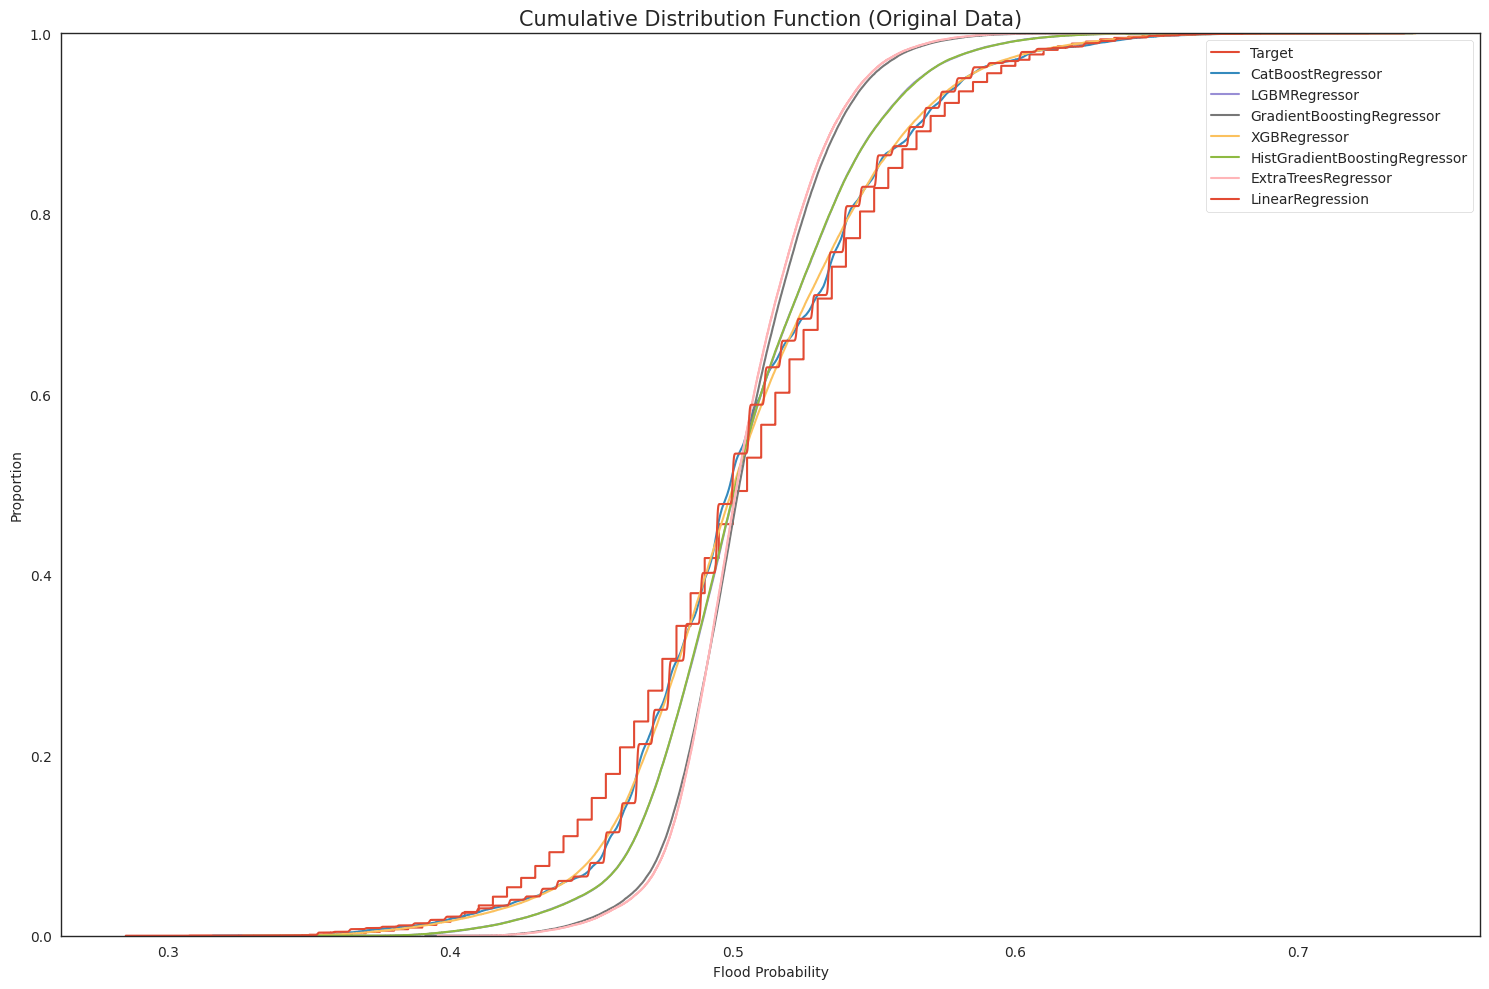

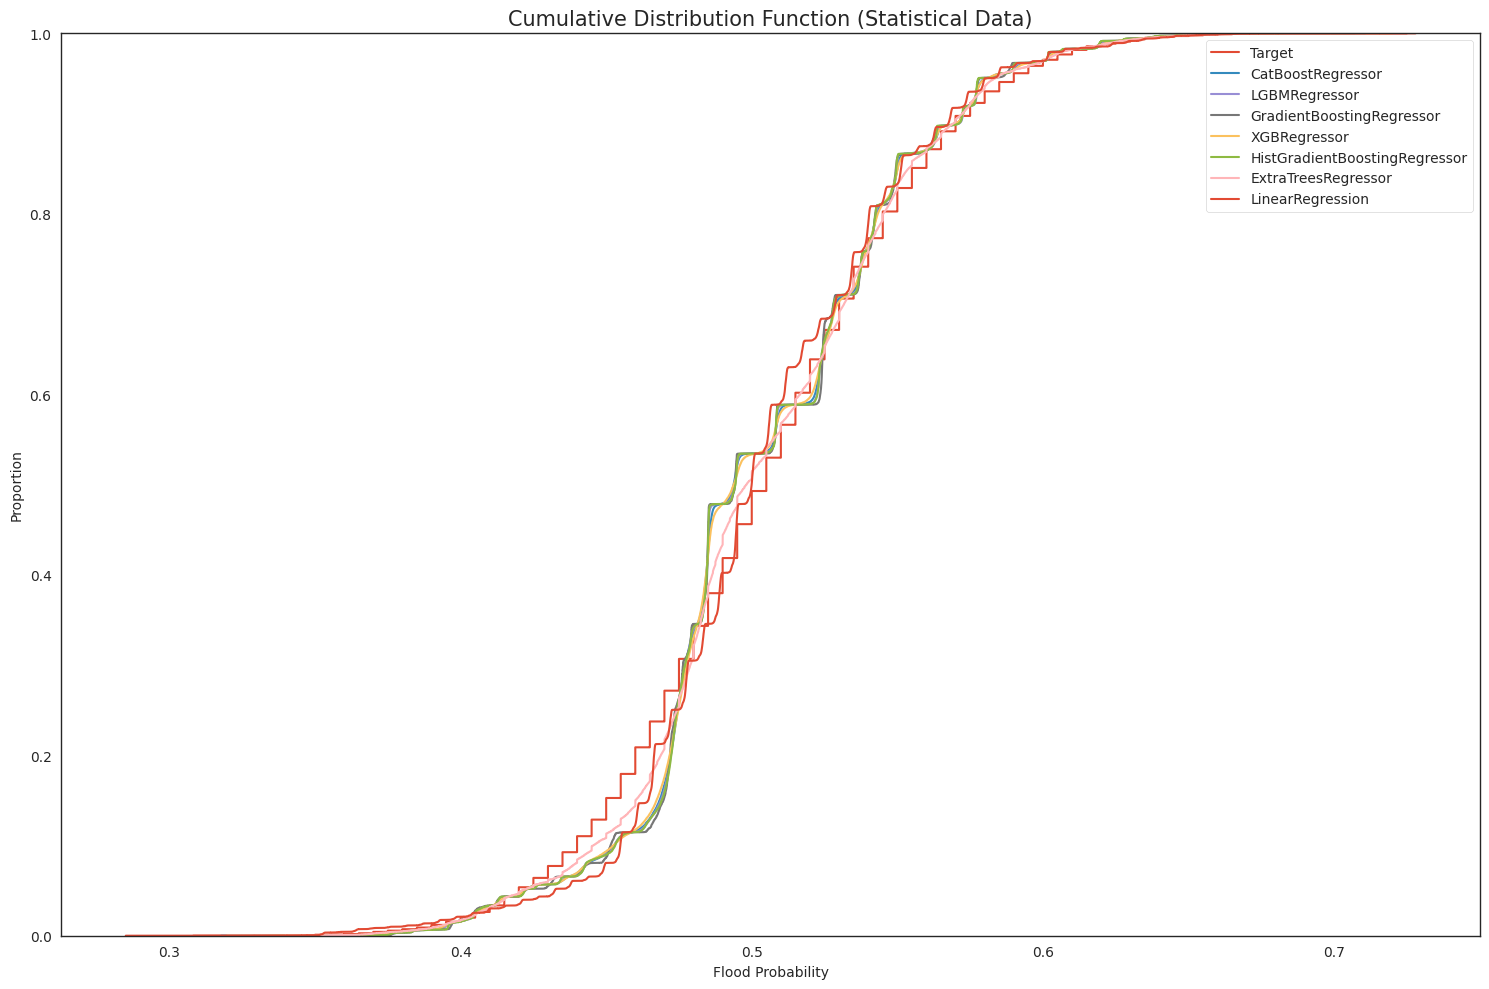

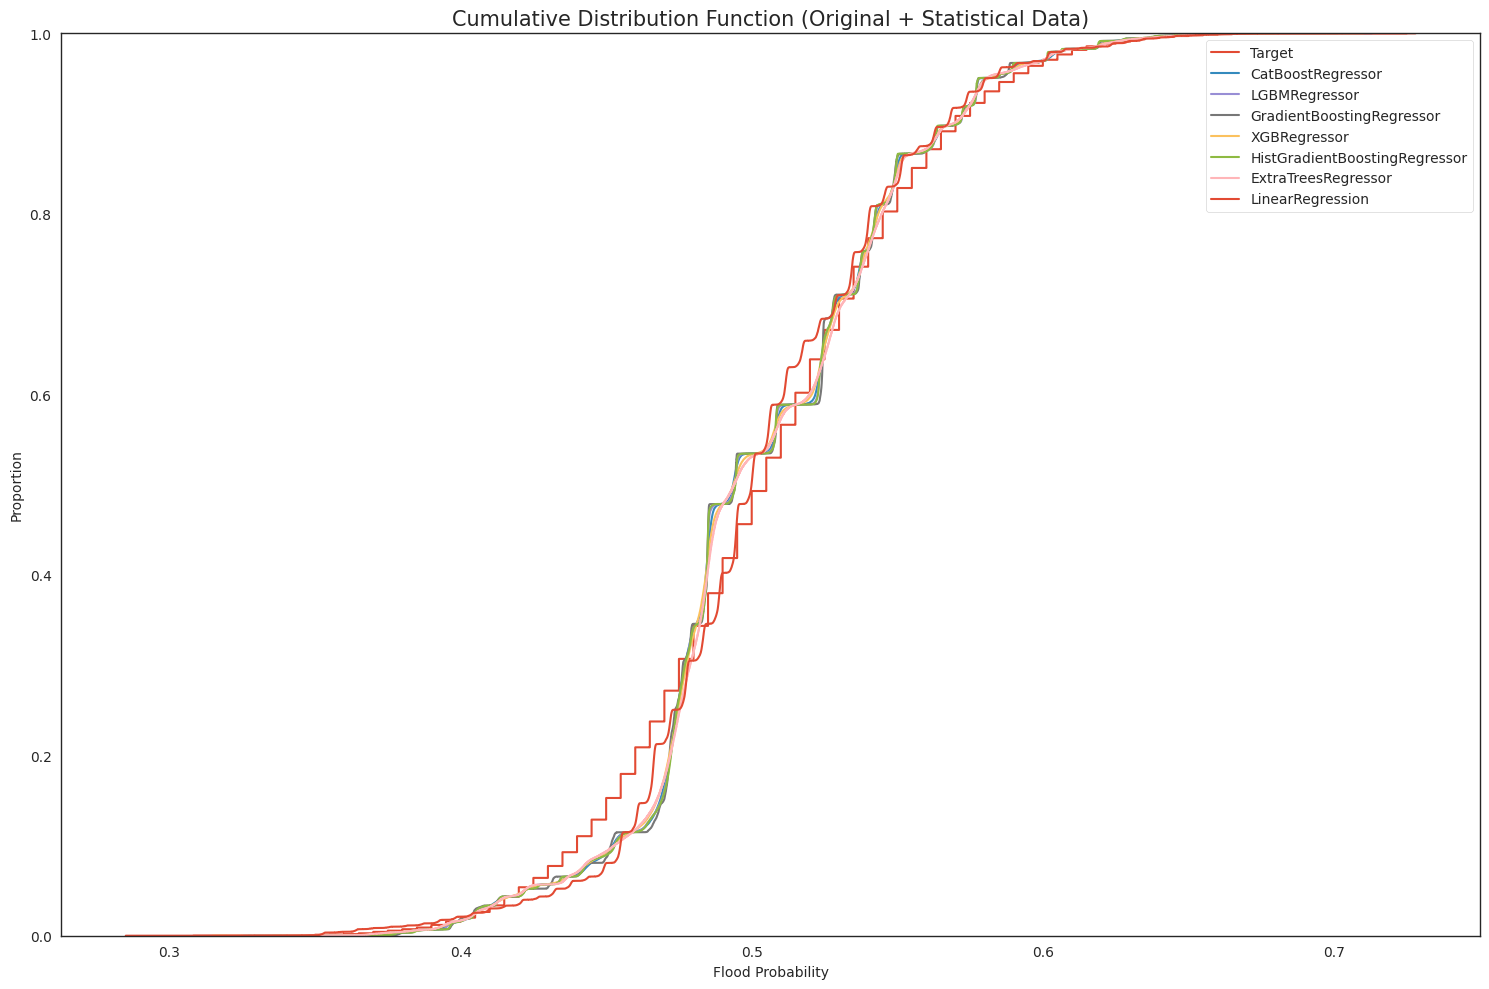

In [19]:
plot_cdfs(model_preds_0, y_0, 'Original Data')
plot_cdfs(model_preds_1, y_1, 'Statistical Data')
plot_cdfs(model_preds_2, y_2, 'Original + Statistical Data')

In [20]:
def plot_all_cdfs(model_preds, y, title):
    sns.set_style("white")
    fig, axs = plt.subplots(2, 4, figsize=[20, 10])

    axs = axs.flatten()
    for ax, (model, preds) in zip(axs, model_preds.items()):
        sns.ecdfplot(data=y, stat='proportion', complementary=False, label='Target', ax=ax)
        sns.ecdfplot(data=preds, stat='proportion', complementary=False, label=model, ax=ax)
        ax.set_title(model, fontsize=15)
        ax.set_xlabel('Flood Probability', fontsize=10)
        ax.set_ylabel('Proportion', fontsize=10)
        ax.legend()
    fig.suptitle(f'Cumulative Distribution Functions ({title})', fontsize=20)

    plt.tight_layout()
    plt.show()

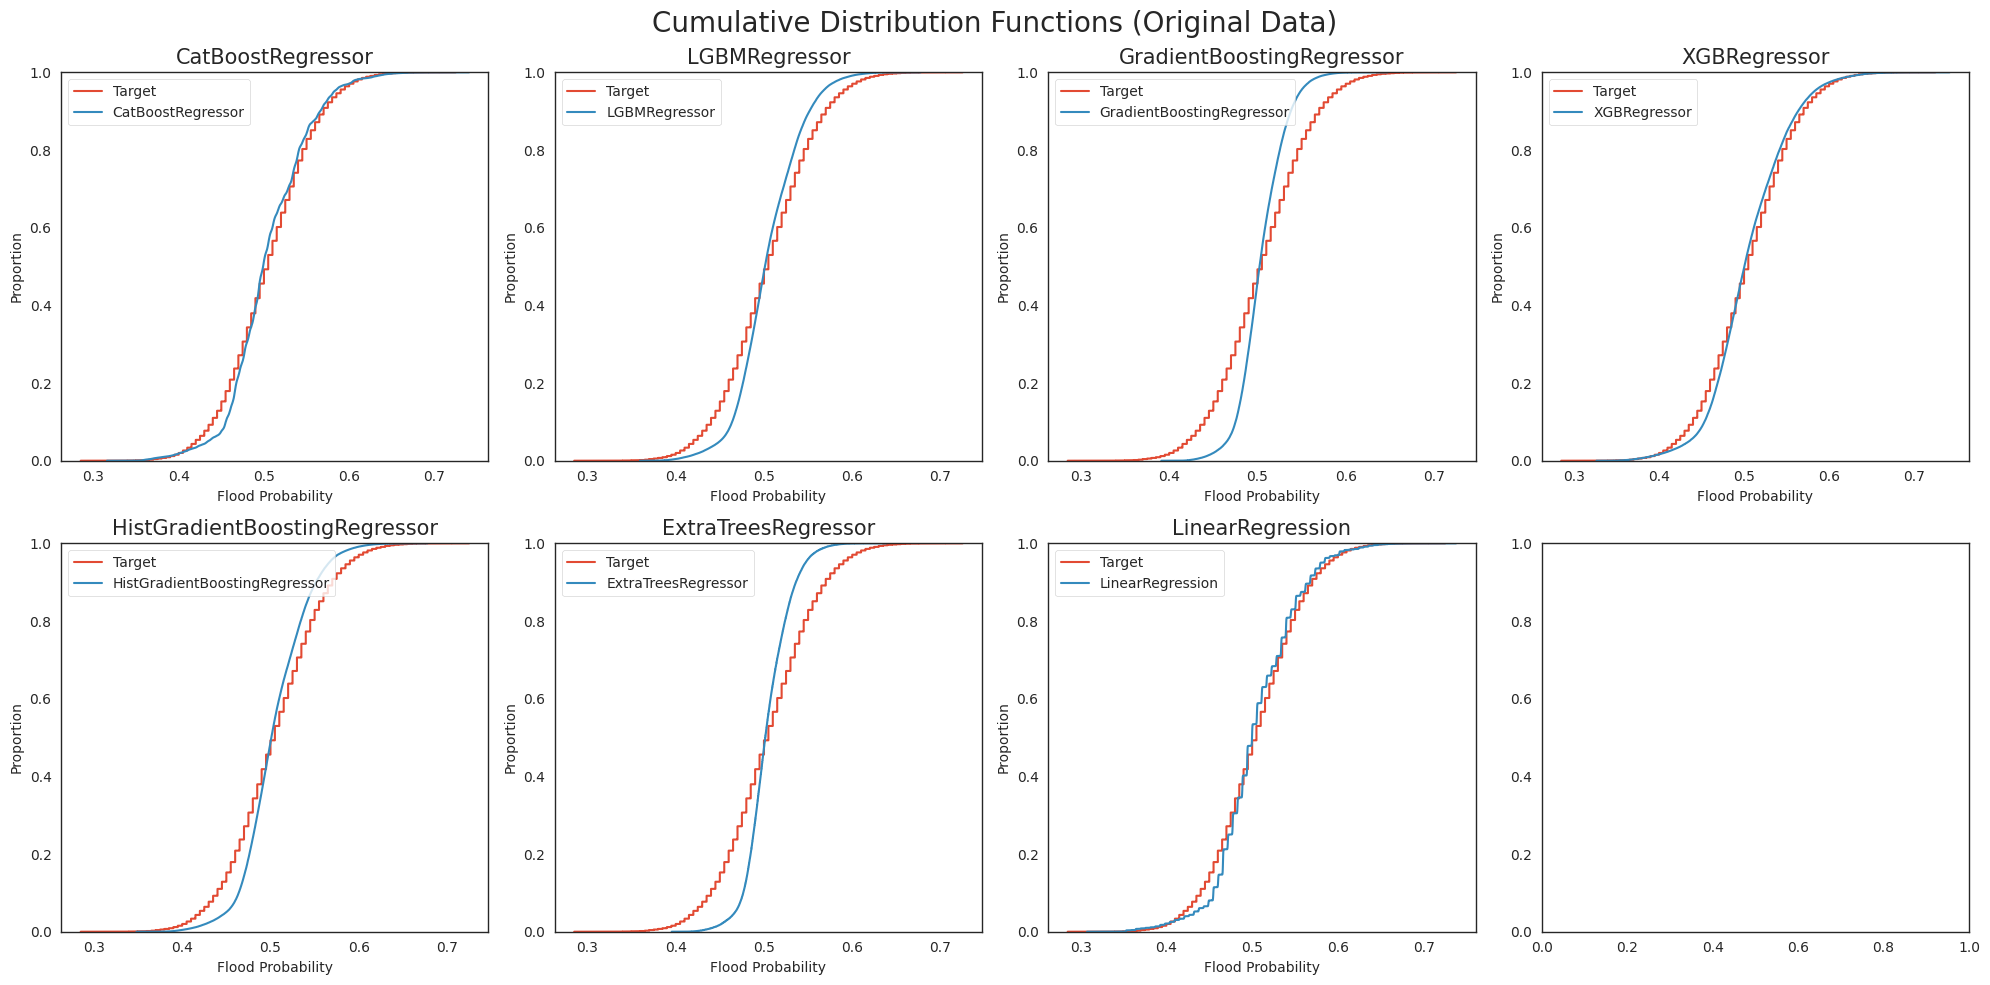

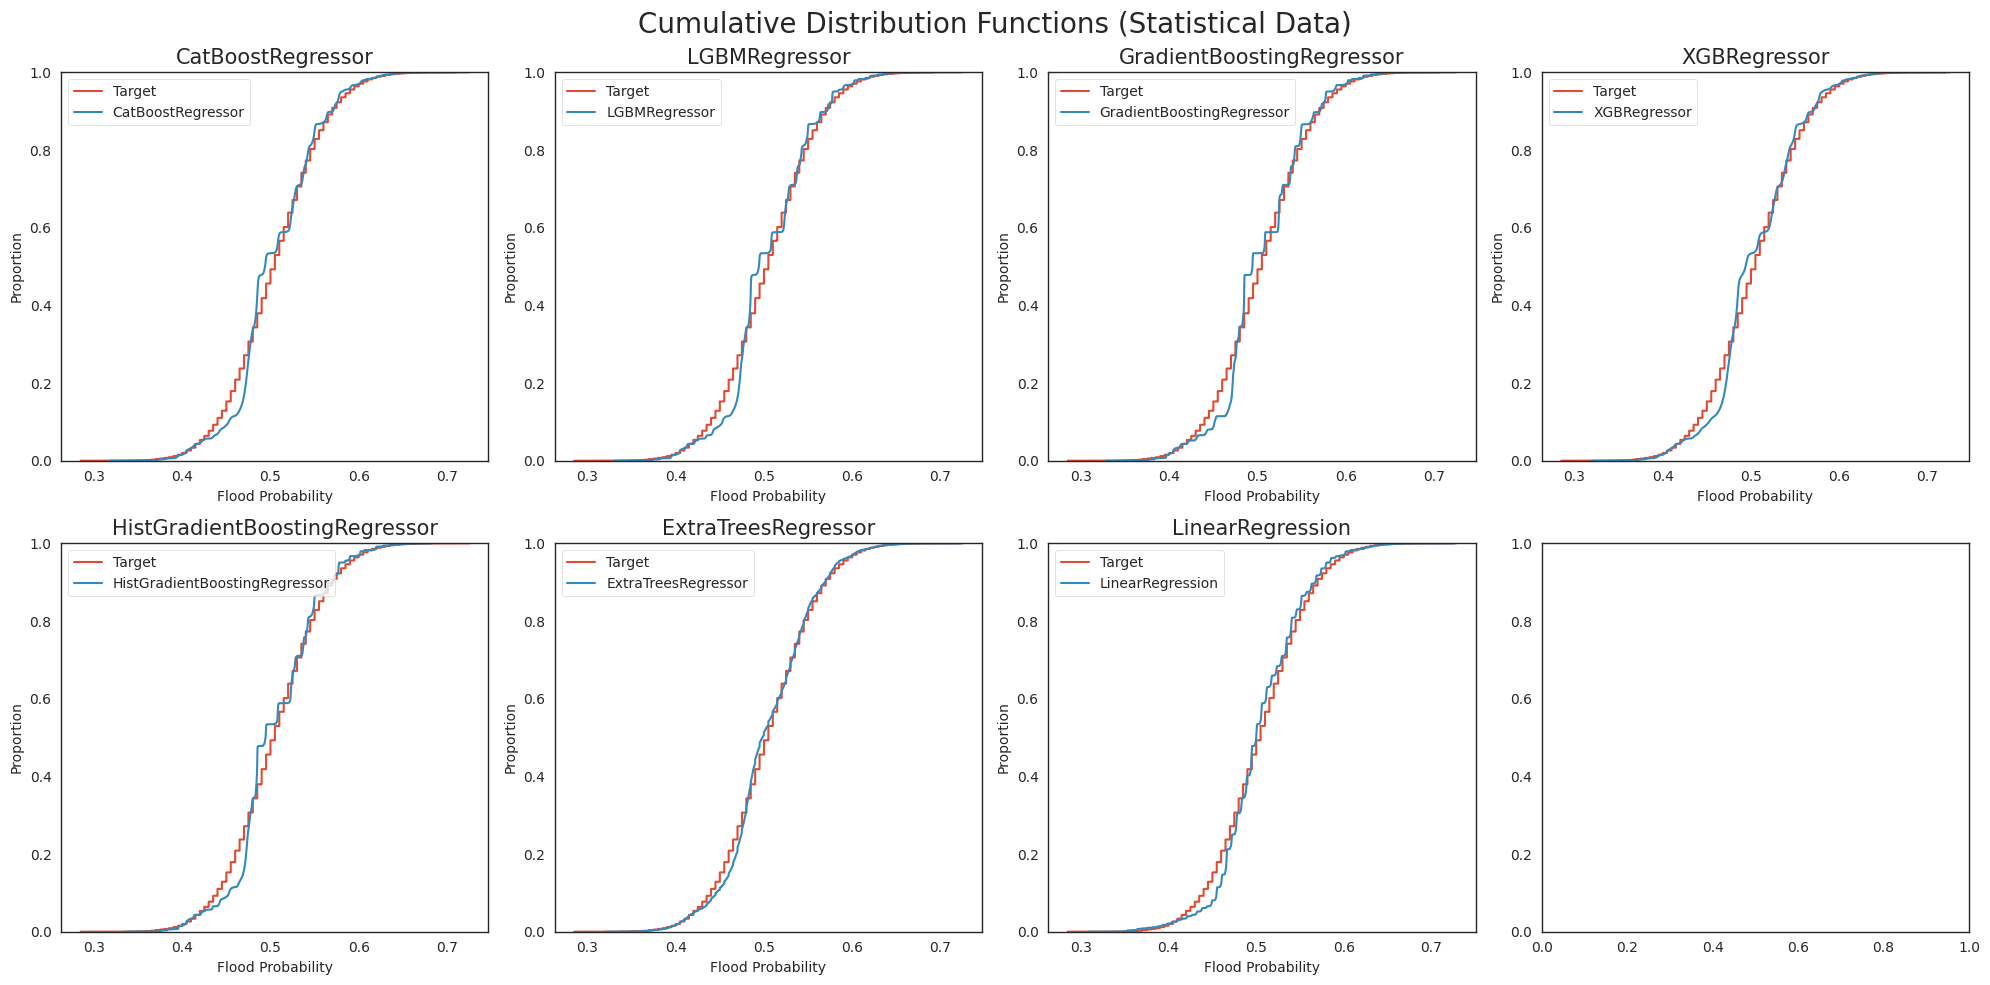

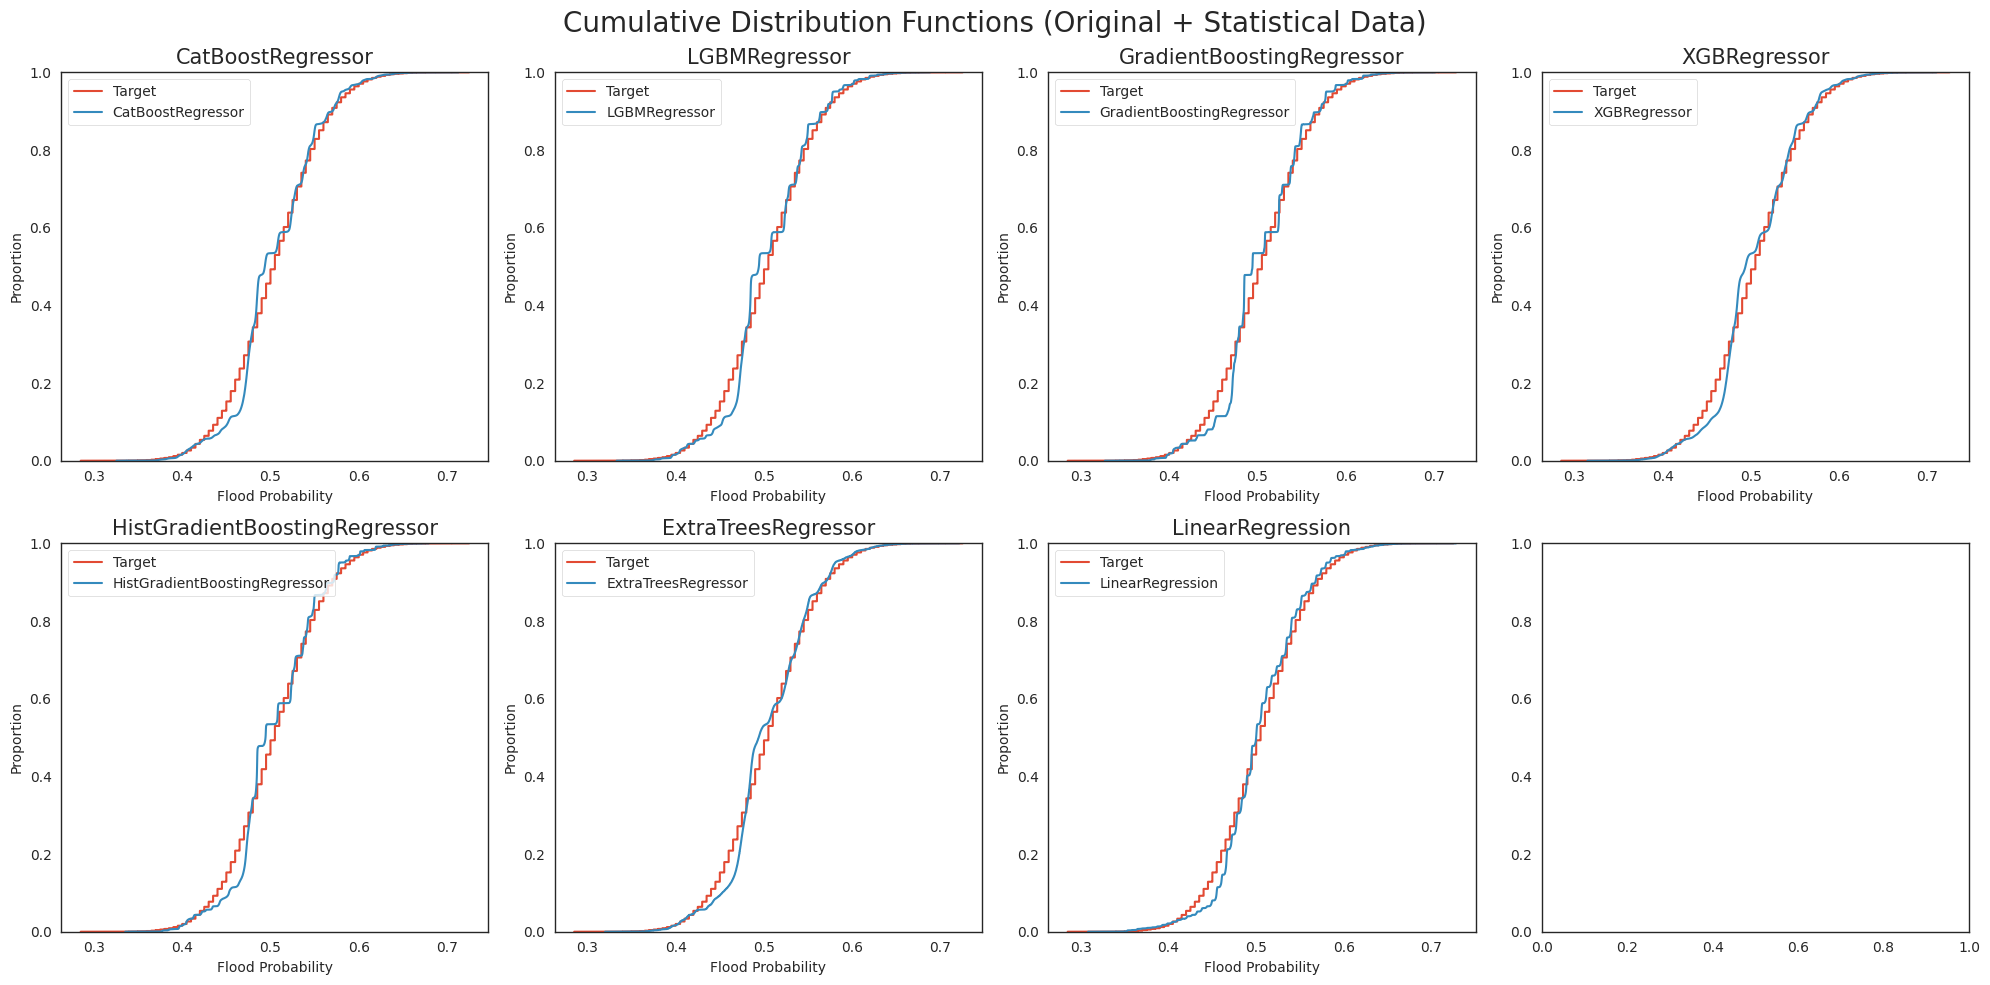

In [21]:
plot_all_cdfs(model_preds_0, y_0, 'Original Data')
plot_all_cdfs(model_preds_1, y_1, 'Statistical Data')
plot_all_cdfs(model_preds_2, y_2, 'Original + Statistical Data')

# Retraining the Best Model and Creating a Submission File

In [22]:
test = add_stat_features(test, feature_cols)
test = test.drop(feature_cols, axis=1)

best_model = LGBMRegressor(random_state=SEED, verbose=-1)
best_model.fit(X_1, y_1)
test_preds = best_model.predict(test)

submission = pd.DataFrame({'id': test.index, 'FloodProbability': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.576826
1,1117958,0.452169
2,1117959,0.448064
3,1117960,0.466195
4,1117961,0.466530
